# 4-1 프로젝트: Semantic segmentation
### 프로젝트 1. 인물 사진 배경 블러 처리
### 프로젝트 2. 강아지 사진 배경 블러 처리
### 프로젝트 3. 인물 사진 배경 변경
##### 가상환경
- python=3.9.7
- CUDA=11.2
- CUDNN=8.1
- tensorflow-gpu==2.7.0
- cmake==3.29.3
- dlib==19.24.99
- matplotlib==3.9.0
- pixellib==0.7.1

___

# 프로젝트 1. 인물 사진 배경 블러 처리
## 0.1 라이브러리

In [129]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

## 0.2 모델 불러오기
- DeepLab 사전 훈련 모델
- 학습된 데이터 : PASCAL VOC
- 라벨의 종류 : 배경 + 20클래스(15:사람, 12:강아지)
### 0.2-1 모델 다운로드

In [130]:
model_dir = 'C:/Users/lkg/Desktop/vscode/human_segmentation/models' # 모델 저장할 디렉토리
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

urllib.request.urlretrieve(model_url, model_file)

('C:/Users/lkg/Desktop/vscode/human_segmentation/models\\deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x2899f1e4940>)

### 0.2-2 모델 정의
- PixelLib 라이브러리의 semantic_segmentation 클래스 인스턴스 생성
- 사전 학습 모델 로드

In [131]:
# semantic_segmentation 객체 생성
model = semantic_segmentation()
# 사전 학습된 PASCAL VOC 모델 로드
model.load_pascalvoc_model(model_file)

### 0.3 학습 모델의 라벨 확인
- PASCAL VOC 데이터셋에서 사용되는 라벨 이름 정리
- 21개의 라벨로 분류
- [15]: 사람, [12]: 강아지

In [132]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

## 1. 인물 이미지
### 1.1 이미지 불러오기

(1371, 1080, 3)


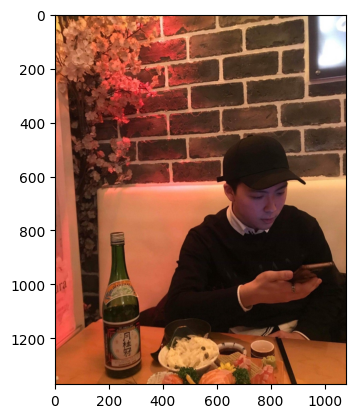

In [133]:
img_path = 'C:/Users/lkg/Desktop/vscode/data/human_segmentation/cap.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## 2. 모델 적용
### 2.1-1 모델에 이미지 입력
- 이미지 분할, 분할출력의 배열 반환
- output: 분할된 이미지
- segvalues: 
  - class_ids: 클래스 ID 목록
  - masks: 각 클래스에 해당하는 마스크 이미지 배열

{'class_ids': array([ 0,  5, 11, 15, 18], dtype=int64), 'masks': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])}


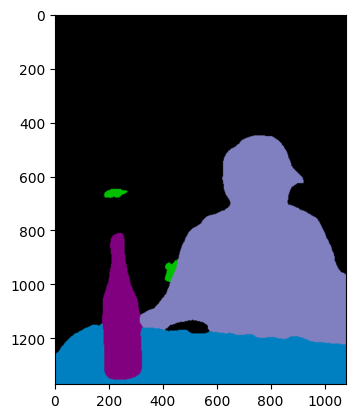

In [134]:
# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)
# 반환값 확인
print(segvalues)
plt.imshow(output)
plt.show()

### 2.1-2 분할 이미지의 라벨
- segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력

In [135]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bottle
diningtable
person
sofa


### 2.2 컬러맵 만들기
- 20개의 컬러맵 확인

In [136]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

### 2.3-1 인물의 컬러맵
- 컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째= 사람)
- RGB 순서

In [137]:
colormap[15] # RGB 순서

array([192, 128, 128])

### 2.3-2 채널 배치 변경
- colormap: RGB
- model output: BGR

In [138]:
seg_color = (128,128,192) # BGR로 변경

### 2.4 선택 채널의 이미지 생성
- seg_color(사람)로만 이루어진 마스크 생성
- output==seg_color => 같음: 1(True) | 다름: 0(False)

(1371, 1080)


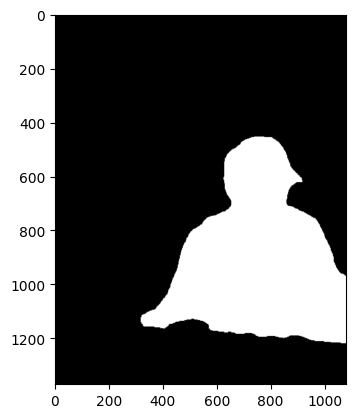

In [139]:
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
seg_map = np.all(output==seg_color, axis=-1) 

print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray') # 흑백
plt.show() # True:1 False:0

## 3. color mask

### 3.1 img_mask 생성
- seg_map의 True|False에 *255

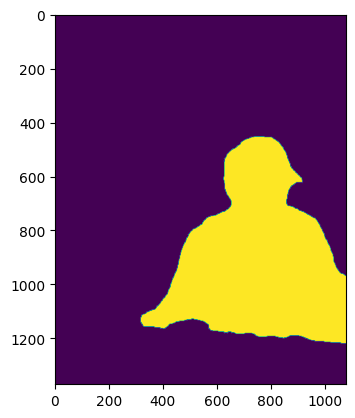

In [140]:
# 원본 이미지 복사
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255
plt.imshow(img_mask)
plt.show()

### 3.2 color_mask
- img_mask에 색상 변경

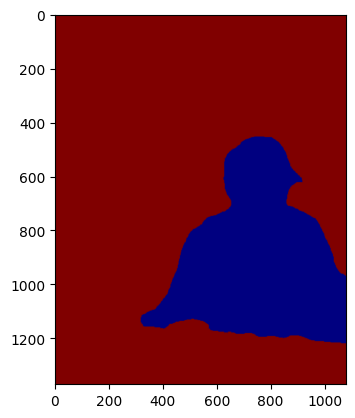

In [141]:
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
plt.imshow(color_mask)
plt.show()

### 3.3 원본이미지 color_mask 적용
- cv2.addWeighted()

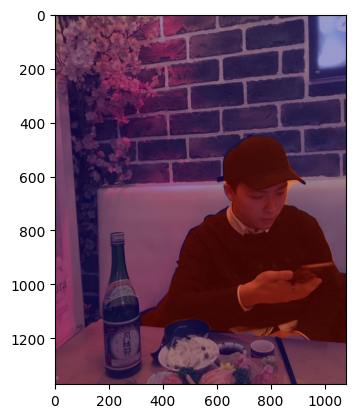

In [142]:
# 원본이미지:컬러마스크=0.6:0.4 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)) # 색상 변경
plt.show()

## 4. 이미지 블러
### 4.1 이미지에 블러 적용
- cv2.blur(img, (50,50)): 높을 수록 흐려짐

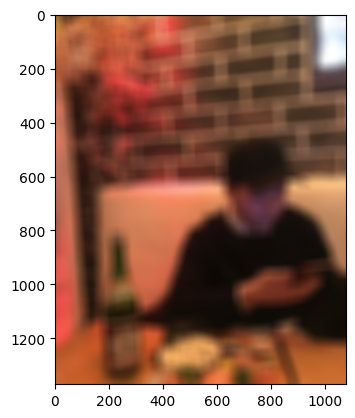

In [143]:
# 원본 이미지에 블러 적용
img_orig_blur = cv2.blur(img_orig, (50,50))

# BGR 형식을 RGB 형식으로 변경
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 4.2 마스크 이미지의 라벨
- 흑백 표시
- img_mask_color : 
  - 사람: 흰색(255) 
  - 배경: 검정(0)
- img_bg_mask :
  - 사람: 검정(0)
  - 배경: 흰색(255)

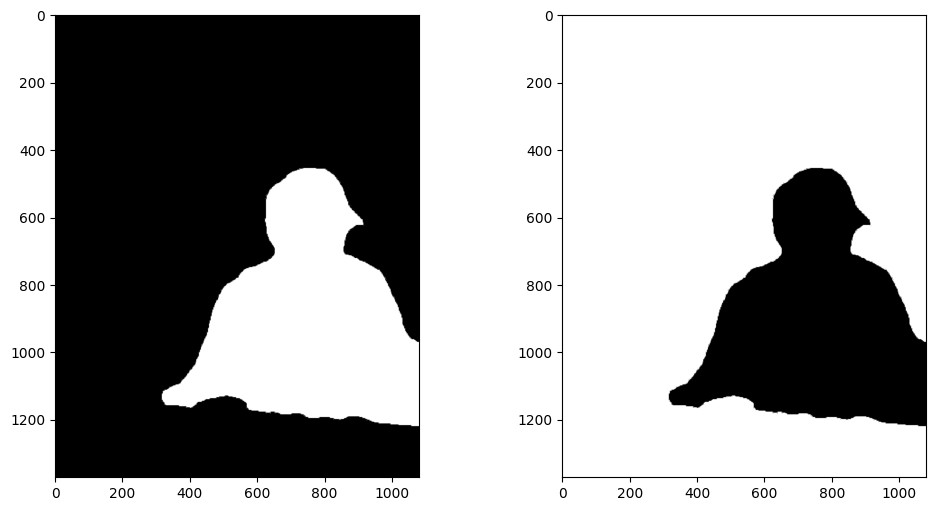

In [144]:
# 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR) # 0,255
# cv2.bitwise_not(): 이미지가 반전됩니다. 배경: 0(검정) 사람: 255 였으나
img_bg_mask = cv2.bitwise_not(img_mask_color)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_mask_color)
axes[1].imshow(img_bg_mask)
plt.show()

### 4.3 블러 이미지, 인물 제거
- cv2.bitwise_and(): 배경만 있는 이미지를 얻을 수 있음
  - 0과 무엇을 and해도 0 반환
  - 사람이 0인 경우 해당 픽셀 0
- img_bg_blur: 흐릿한 배경, 검정 사람 이미지 형태

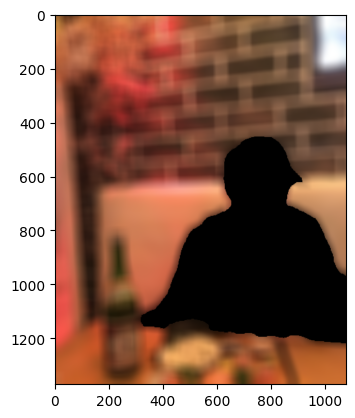

In [145]:
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask) # 흐릿배경,검정사람

plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 5. 결과
- np.where(): img_bg_mask가 0일때 원본, 아닐경우 블러 이미지

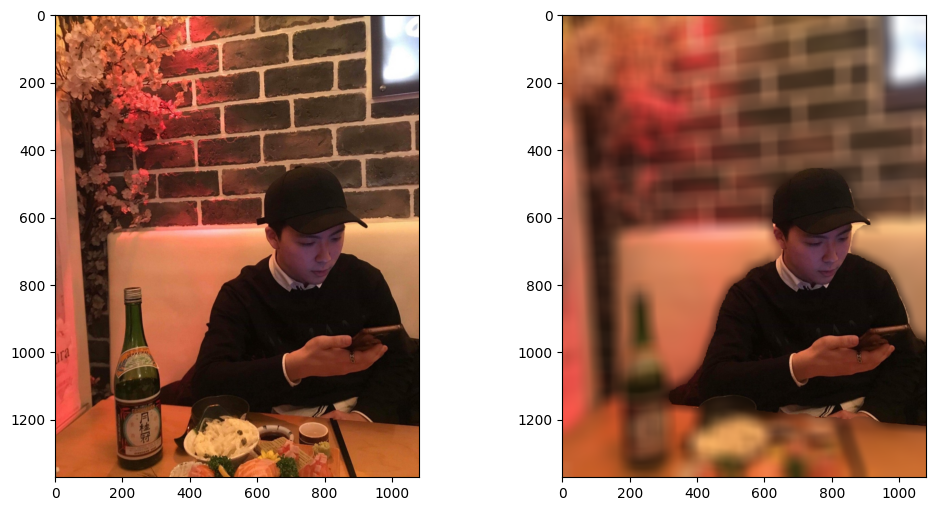

In [146]:
# img_bg_mask: 0=사람 255=배경
img_concat = np.where(img_bg_mask==0, img_orig, img_bg_blur)
img_concat = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB) # 색상 변경

# 비교
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)) # 원본이미지
axes[1].imshow(img_concat) # 블러 이미지
plt.show()

## 6. 블러 실패 비교

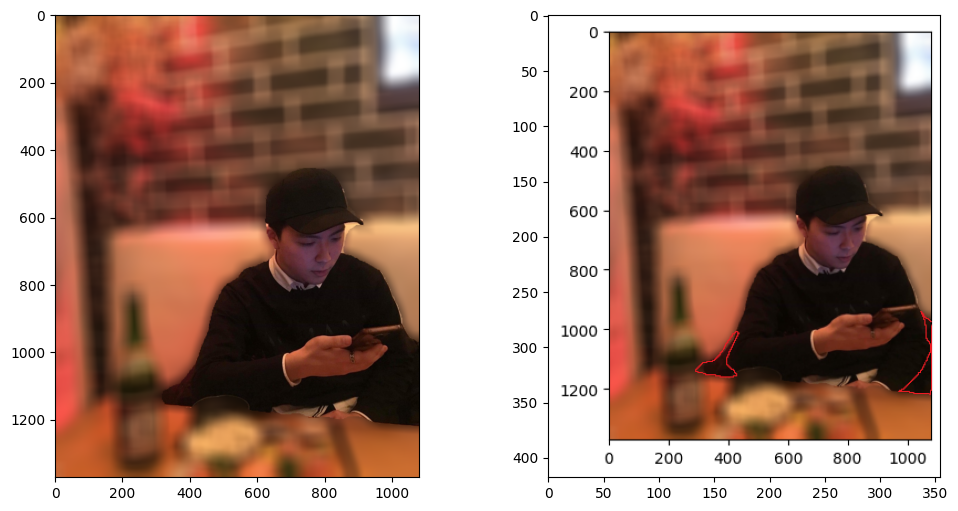

In [147]:
out_path = 'C:/Users/lkg/Desktop/vscode/data/human_segmentation/output.png'  
out_orig = cv2.imread(out_path) 
out_orig = cv2.cvtColor(out_orig, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_concat)
axes[1].imshow(out_orig)
plt.show()

___

# 프로젝트 2. 강아지 사진 배경 블러 처리

(2992, 2992, 3)


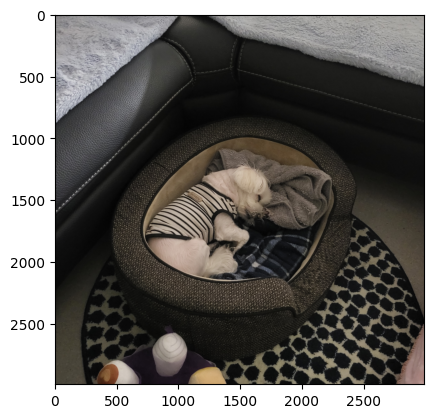

In [148]:
img_path = 'C:/Users/lkg/Desktop/vscode/data/human_segmentation/dog.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

### 모델에 이미지 적용
- 강아지의 옷이 사람으로 인지 됨

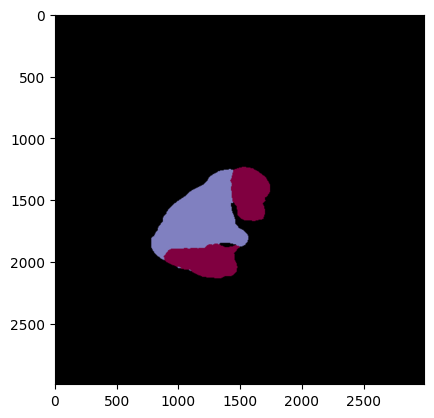

background
dog
person


In [149]:
# 모델에 이미지 적용
segvalues, output = model.segmentAsPascalvoc(img_path)
plt.imshow(output)
plt.show()
# segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

### 강아지 라벨
- = 12

In [150]:
# 강아지 라벨 확인
print(LABEL_NAMES.index('dog'))
print(colormap[12])
seg_color = (128,0,64)

12
[ 64   0 128]


### 전체 이미지 블러 적용

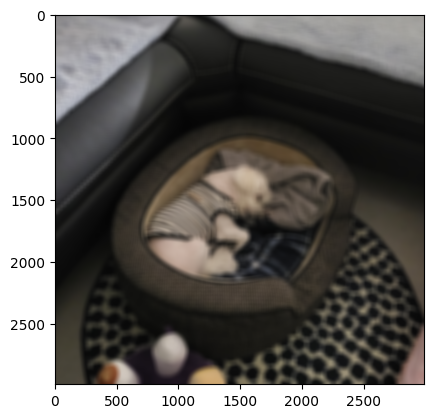

In [151]:
seg_map = np.all(output==seg_color, axis=-1) 
img_mask = seg_map.astype(np.uint8) * 255
img_orig_blur = cv2.blur(img_orig, (50,50))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 결과: 강아지 블러 적용

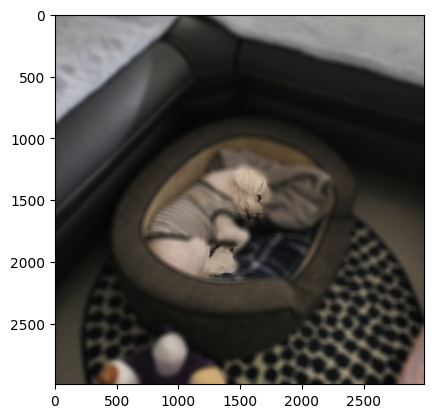

In [152]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR) 
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

img_concat = np.where(img_bg_mask==0, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 결과 비교
- 강아지의 옷이 사람으로 인지
  - 이유: 옷을 입고 있는 것을 모델이 사람으로 인지하려는 경향이 있을 것 같다.
- Semantic segmentation 실패
  - 개선방법: 사람으로 인지된 옷+강아지를 제외한 배경을 블러

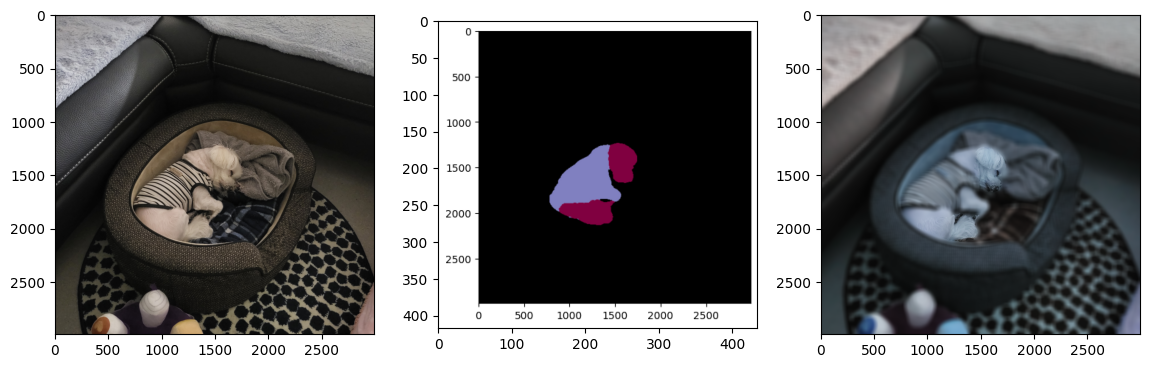

In [153]:
out_path = 'C:/Users/lkg/Desktop/vscode/data/human_segmentation/output2.png'  
out_orig = cv2.imread(out_path) 
out_orig = cv2.cvtColor(out_orig, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 3, figsize=(14, 6))
axes[2].imshow(img_concat)
axes[1].imshow(out_orig)
axes[0].imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

___

# 프로젝트 3. 인물 사진 배경 변경

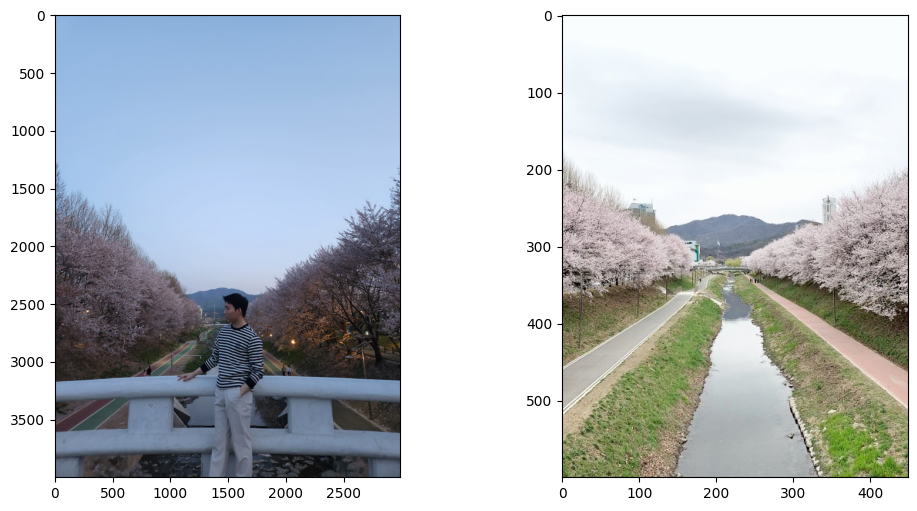

In [154]:
# 원본 이미지 업로드
img_path = 'C:/Users/lkg/Desktop/vscode/data/human_segmentation/blossom.png'  
img_orig = cv2.imread(img_path) 
img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
# 배경 이미지 업로드
back_path = 'C:/Users/lkg/Desktop/vscode/data/human_segmentation/back.png'  
back_orig = cv2.imread(back_path) 
back_rgb = cv2.cvtColor(back_orig, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_rgb)
axes[1].imshow(back_rgb)
plt.show()

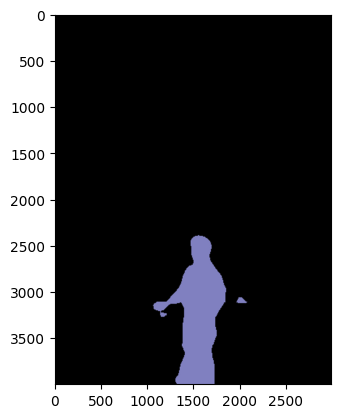

In [155]:
segvalues, output = model.segmentAsPascalvoc(img_path)
plt.imshow(output)
plt.show()

(4000, 2992)


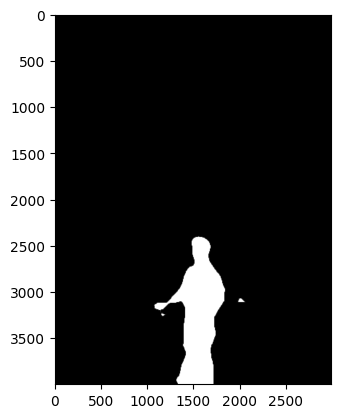

In [156]:
seg_color = (128,128,192)
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

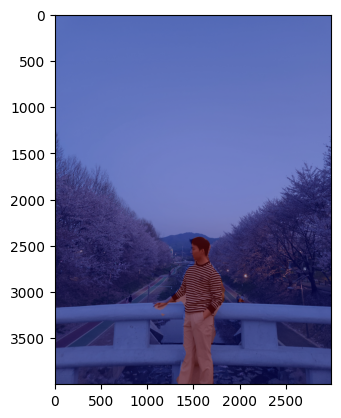

In [157]:
img_show = img_orig.copy()
img_mask = seg_map.astype(np.uint8) * 255

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))

### 배경 이미지 크로마키

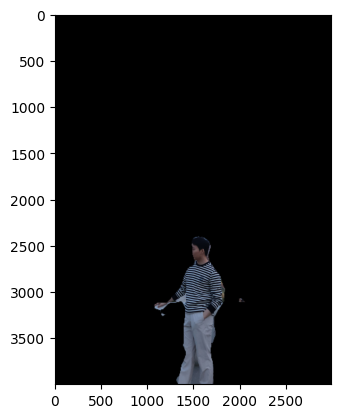

In [159]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_blur = cv2.bitwise_and(img_rgb, img_mask_color)
plt.imshow(img_bg_blur)

### 결과: 배경 합성

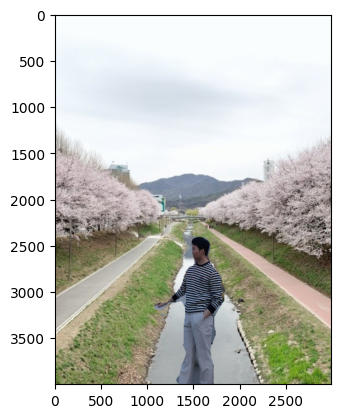

In [160]:
img_bg_mask = cv2.bitwise_not(img_mask_color)

# 배경 이미지를 원본 이미지의 사이즈로 맞춰줌
back_orig = cv2.resize(back_orig, (img_orig.shape[1], img_orig.shape[0]))
# 크로마키에 이미지 적용
img_concat = np.where(img_bg_blur==0, cv2.cvtColor(back_orig, cv2.COLOR_BGR2RGB), img_rgb)

plt.imshow(img_concat)
plt.show()

## 결과 비교
- 원본 이미지의 배경을 새로운 이미지로 변경해 보았다
- 배경 이미지의 사진의 크기는 원본 이미지의 크기와 같아야 한다

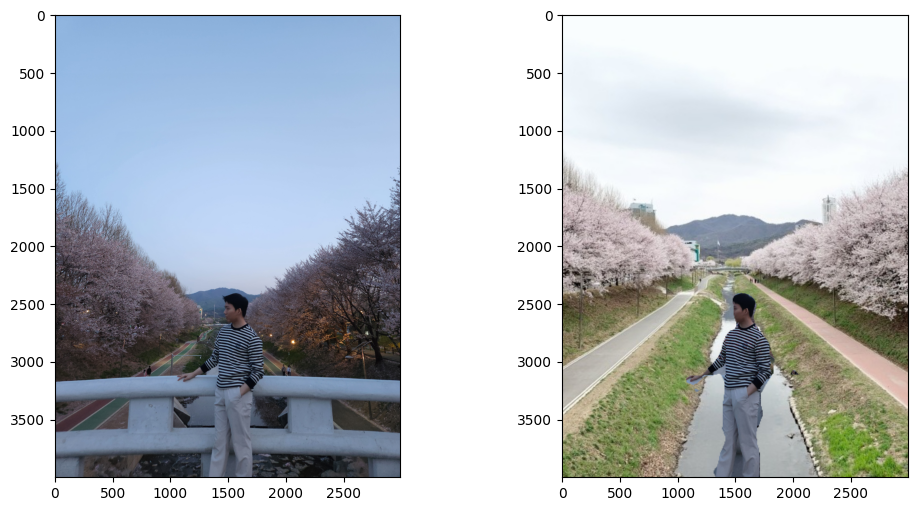

In [161]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_rgb)
axes[1].imshow(img_concat)
plt.show()

___

# 한계 및 개선 방법

### 세그멘테이션의 한계
- Semantic segmentation의 부정확성이 여러 문제의 원인이다
- 피사계심도를 이용한 아웃포커싱 효과는 심도를 표현하기 때문에 초점이 잡힌 거리를 잘 구별하지만,
- semantic segmentaion의 경우 정확도가 1.00이 아니라면 완벽한 구별은 어렵다.
___
### 3D 카메라를 사용
1. 3D 카메라로 RGB 이미지와 깊이 데이터를 얻는다
   - pyrealsense2 라이브러리를 사용하여 RealSense 카메라로부터 RGB 이미지와 깊이 데이터를 캡처
2. DeepLab 모델로 세그멘테이션 마스크 생성한다
   - PixelLib을 사용하여 DeepLab 모델로부터 세그멘테이션 마스크를 생성
3. RGB 이미지와 깊이 데이터를 결합한다
   - 마스크 영역을 기준으로 깊이 데이터를 추출하고, 이를 컬러 맵으로 변환하여 시각적으로 표시
4. 마스크 영역에 깊이 데이터를 적용한다
   - 원본 이미지와 깊이 맵을 결합하여 결과 이미지를 생성

#### 중요 코드
1. 프레임 캡처
   - frames = pipeline.wait_for_frames()
   - color_frame = frames.get_color_frame()
   - depth_frame = frames.get_depth_frame()
2. 이미지 세그멘테이션
   - segvalues, output = model.segmentAsPascalvoc(color_image)
3. 깊이 데이터 마스크 영역 추출
   - depth_masked = np.where(mask == 1, depth_image, 0)
4. 색상 맵 적용
   - color_depth = cv2.applyColorMap(cv2.convertScaleAbs(depth_masked, alpha=0.03), cv2.COLORMAP_JET)
___
### 소프트웨어 기술 활용
- 비욜의 문제를 제한된 하드웨어를 이용하며 소프트웨어로 한계를 극복
  - 구글-struct2Depth
1. 동영상 또는 이미지 시퀀스에서 프레임 추출
   - 비디오 파일에서 프레임을 추출하여 리스트에 저장
2. DeepLab 모델로 세그멘테이션 마스크 생성
   - PixelLib을 사용하여 DeepLab 모델로부터 세그멘테이션 마스크를 생성
3. Struct2Depth로 깊이 정보 추정
   - Struct2Depth 모델을 사용하여 입력 이미지(프레임)에서 깊이 맵을 예측
4. 마스크 영역에 깊이 정보 적용
   - 세그멘테이션 마스크를 사용하여 관심 영역의 깊이 정보를 추출하고 이를 시각화

#### 중요코드
1. 프레임 추출
   - ret, frame = cap.read()
   - frames = []
   - while ret:
      - frames.append(frame)
      - ret, frame = cap.read()
2. 첫 번째 프레임에서 세그멘테이션
   - segvalues, output = model.segmentAsPascalvoc(frames[0])
3. 첫 번째 프레임에서 깊이 예측
   - input_image = tf.convert_to_tensor(frames[0])
   - input_image = tf.image.resize(input_image, [192, 256])
   - input_image = tf.expand_dims(input_image, axis=0)
4. 깊이 맵을 컬러로 변환하여 시각화
   - color_depth = cv2.applyColorMap(cv2.convertScaleAbs(masked_depth, alpha=0.03), cv2.COLORMAP_JET)
___
### Mask R-CNN
- __Detectron2__ 라이브러리 이용
- 객체 탐지와 세그멘테이션을 동시에 수행하는 모델
- 객체의 경계와 마스크를 더 정밀하게 추출 한다

### U2-Net
- __PyTorch__ 라이브러리 이용
- 사람과 배경을 분리하는 데 특히 뛰어난 모델
- 매우 정교한 세그멘테이션 결과를 제공

### CRF
- __pydensecrf__ 라이브러리 이용
- 후처리를 적용
- 공간적 정보와 색상 정보를 사용하여 세그멘테이션 결과의 경계를 정밀하게 조정
___
### 위의 두가지 문제 개선방안
- '옷과 사람의 구분 실패', '강아지의 옷을 사람으로 인지' 에 대한 해결 방법으로 개선할 수 있을 것 같다
- '옷과 사람의 구분 실패'의 경우
  1. Mask R-CNN을 통해 더 정교한 모델을 사용하여 객체를 탐지하고 세그멘테이션을 수행한다.
  2. 3D카메라를 사용하여 인물과 배경옷의 거리를 구별한다.
- '강아지의 옷을 사람으로 인지'의 경우
  1. Mask R-CNN을 통해 더 정교한 모델을 사용하여 객체를 탐지하고 세그멘테이션을 수행한다.
  2. 더 많은 데이터셋으로 모델을 훈련한다. (강아지가 옷입고 있는 사진)
